In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random

# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [2]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
%matplotlib notebook
np.random.seed(123)

In [3]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal, start)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    fig = G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)   
    return n, n_cfg, demo, fig

In [4]:
def total_reward(trajectory, grid):
    reward = 0
    count_cs = 0
    count_ca = 0
    count_cc = 0
    for state in trajectory.transitions():
        #check for action constraints violation
        reward += grid.reward[state]
        for constraint in ca:
            if (state[1] == constraint.idx): 
                count_ca += 1
                
        #check for color constraints violation        
        for constraint in cc:
            if (state[0] == constraint): 
                count_cc += 1
                
        #check for state constraints violation
        for constraint in cs:
            if (state[0] == constraint): 
                count_cs += 1
                
    return reward, count_cs, count_ca, count_cc
        

# calculate the kl divergence
def kl_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))
    
# calculate the js divergence
def js_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

#count how many times a state is visited, and compute the average length of the trajectories
def count_states(trajectories, grid):
    count_matrix = np.ones((8,9,9)) * 1e-10
    avg_length = 0.0
    avg_reward = 0.0
    avg_violated = 0.0
    n = len(trajectories)
    for trajectory in trajectories:
        avg_length += len(trajectory.transitions())
        #print(trajectory)
        #print(list(trajectory.transitions()))
        reward, count_cs, count_ca, count_cc = total_reward(trajectory, grid)
        avg_reward += reward
        avg_violated += (count_cs + count_ca + count_cc)
        for state in trajectory.states():
            #print(state)
            count_matrix[0][grid.world.state_index_to_point(state)] += 1
            
    return count_matrix / n, avg_length / n, avg_reward / n, avg_violated / n

In [5]:
def generate_constraints():
    list_available = [x for x in range(81)] #generate the list of non-constrained states

    blue = np.random.choice(list_available, 6) # blue states
    list_available = np.setdiff1d(list_available, blue) # remove blue states from the list of non-constrained states

    green = np.random.choice(list_available, 6) # green states
    list_available = np.setdiff1d(list_available, green) # remove green states from the list of non-constrained states

    cs = np.random.choice(list_available, 6) # constrained states
    list_available = np.setdiff1d(list_available, cs) # remove constrained states from the list of non-constrained states

    #print(blue)
    #print(green)
    #print(cs)
    #print(list_available)

    start = random.choice(list_available) # generate start state from the list of non-constrained states 
    goal = random.choice(list_available) # generate terminal state from the list of non-constrained states

    return blue, green, cs, start, goal

# Nominal world

<IPython.core.display.Javascript object>


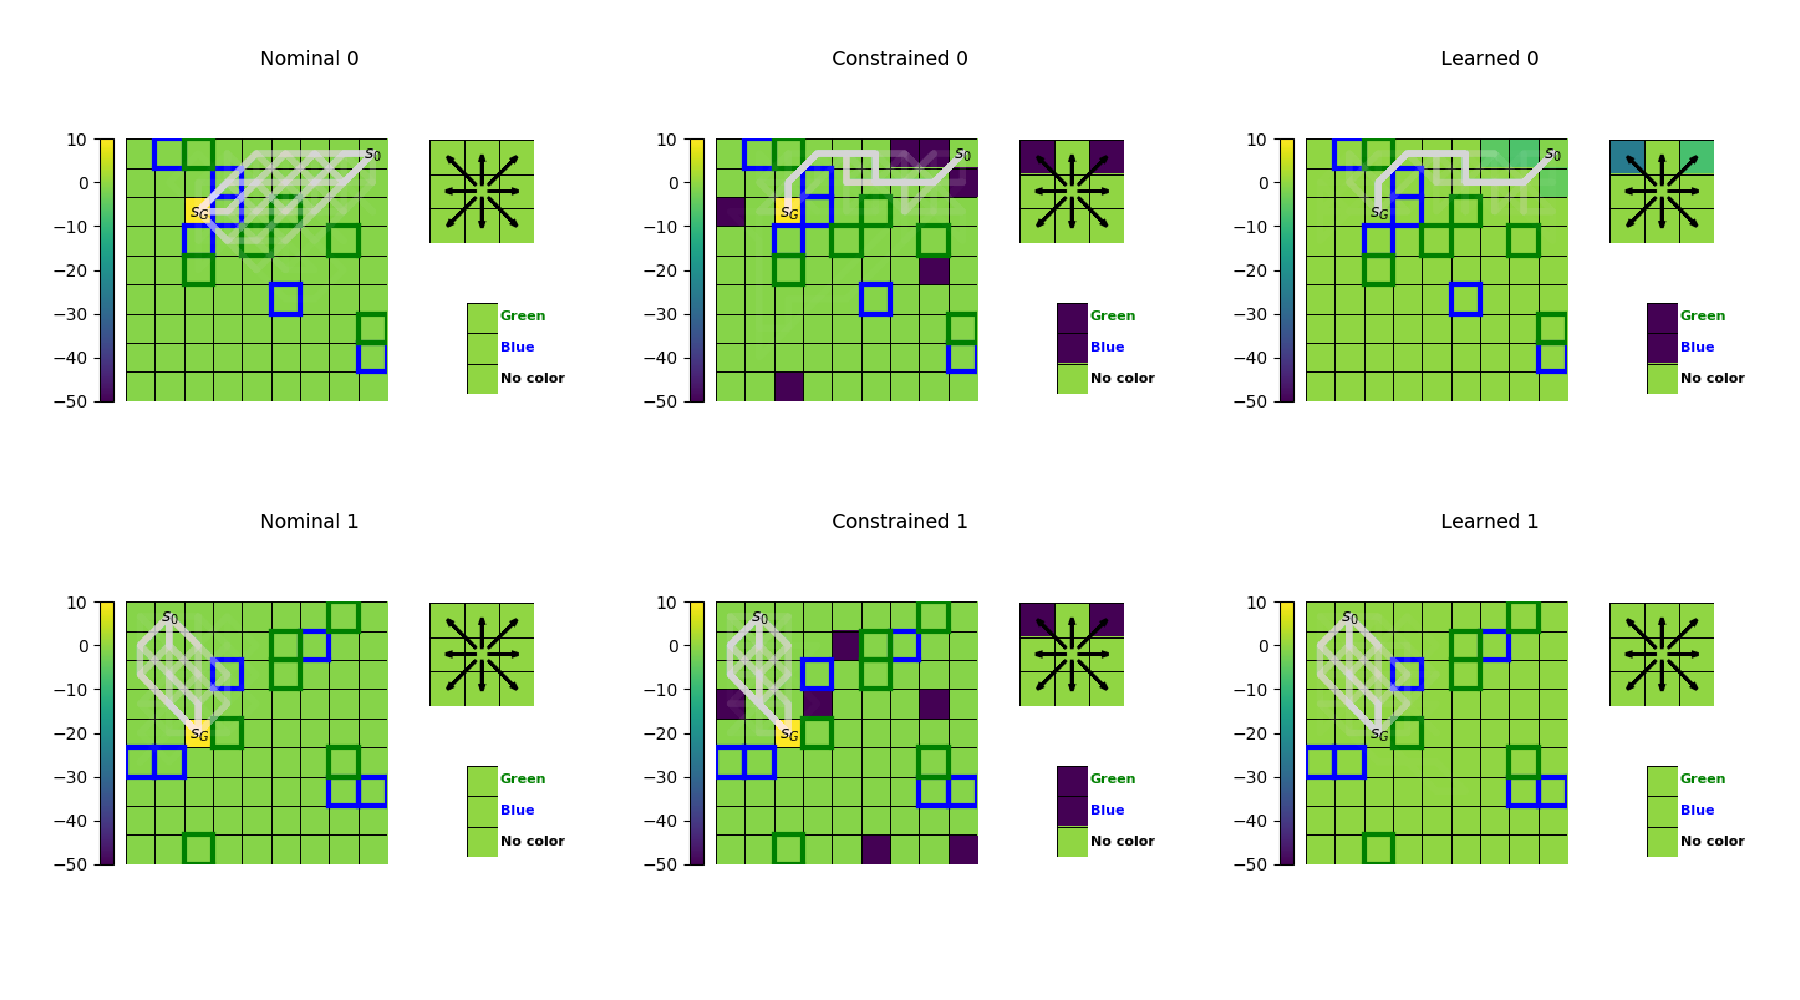

<IPython.core.display.Javascript object>


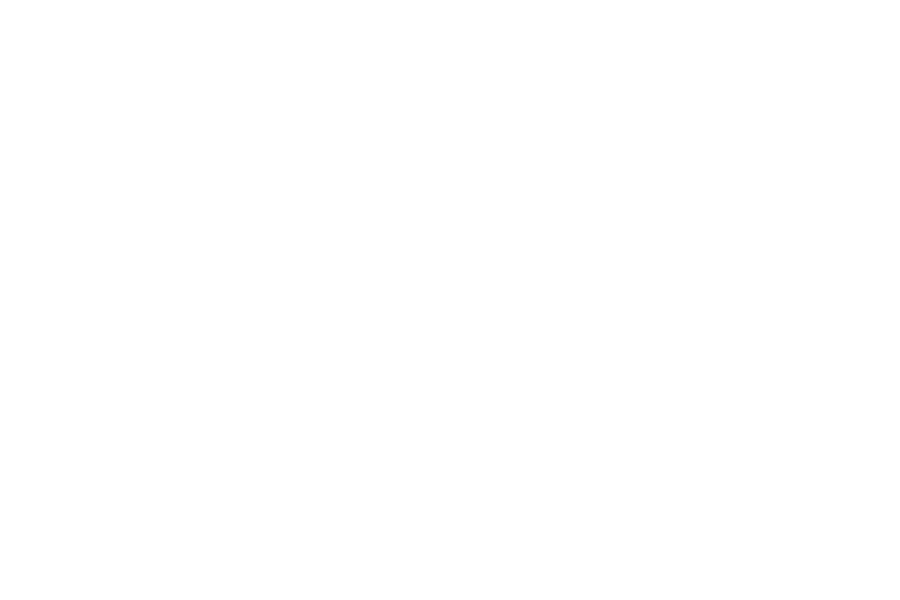

         1: DELTA:  0.00000, MAE:  0.211122668356897
       101: DELTA:  0.13149, MAE:  0.058719461628433
       201: DELTA:  0.19460, MAE:  0.028785985495765
       301: DELTA:  0.28456, MAE:  0.016039021181752
       401: DELTA:  0.35270, MAE:  0.015258363479094


<IPython.core.display.Javascript object>


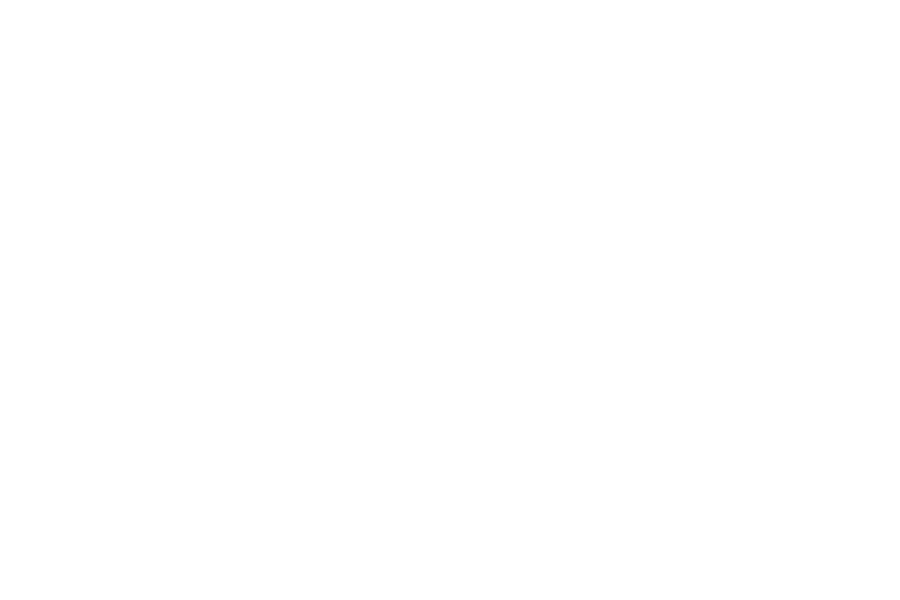

<IPython.core.display.Javascript object>


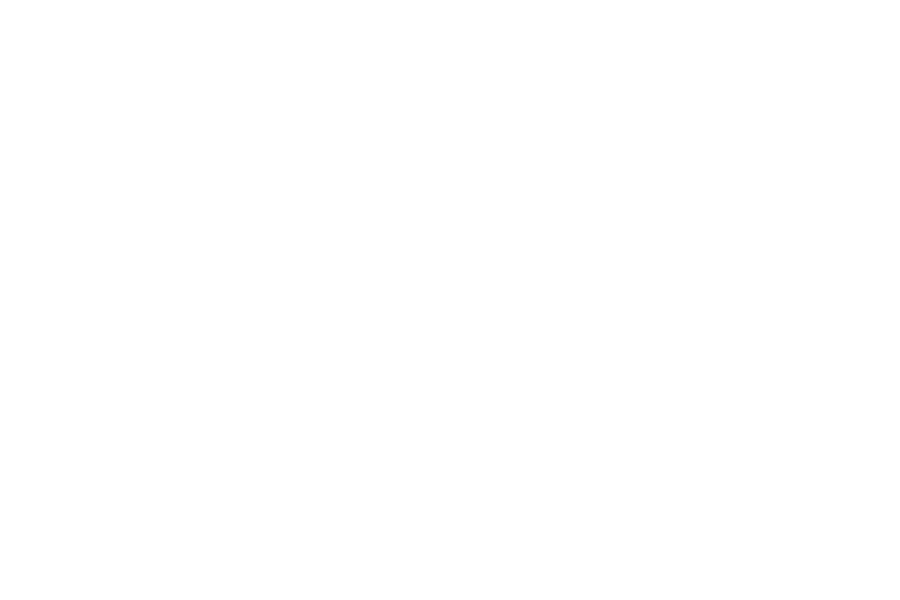

         1: DELTA:  0.00000, MAE:  0.030735027819121


<IPython.core.display.Javascript object>


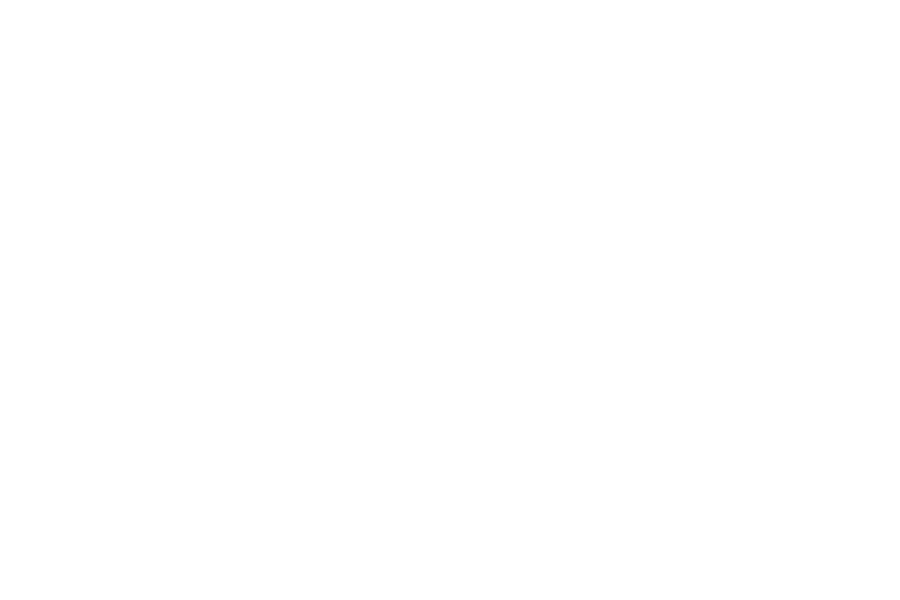

In [6]:
n_tests = 2
fig = plt.figure(figsize=(9, 5))
axis = fig.subplots(n_tests, 3)

worlds =[]

# GENERATE 9 NOMINAL WORLDS
for i in range(n_tests):
    blue, green, cs, start, goal = generate_constraints()

    plt.ioff()
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)

    plt.close()
    plt.ion()
    canvas = FigureCanvas(f1)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i
    y = 0 
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'Nominal {i}', fontsize=7)
    axis[x,y].imshow(X)
    
    #cs = [31, 39, 41, 47, 51]  # constrained states
    ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
    cc = [1, 2]  # constrained colors

    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal)
    
    plt.close()
    plt.ion()
    canvas = FigureCanvas(f2)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i
    y = 1 
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'Constrained {i}', fontsize=7)
    axis[x,y].imshow(X)
    
    learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)
    learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
    demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)

    #print(c.world)
    rl_matrix, avg_rl, avg_reward, avg_violated = count_states(demo_l[0], c)
    #print(avg_reward)
    #print(avg_violated)

    p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
                  learned_params.action_weights, learned_params.color_weights, 
                  demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    
    plt.close()
    plt.ion()
    canvas = FigureCanvas(p)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i
    y = 2 
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'Learned {i}', fontsize=7)
    axis[x,y].imshow(X)
    
    worlds.append({'n': n_cfg,'c': c_cfg,'learned_params': learned_params,'learned_mdp': learned_mdp})

    
    
fig.tight_layout()

## Learn constraints

<IPython.core.display.Javascript object>


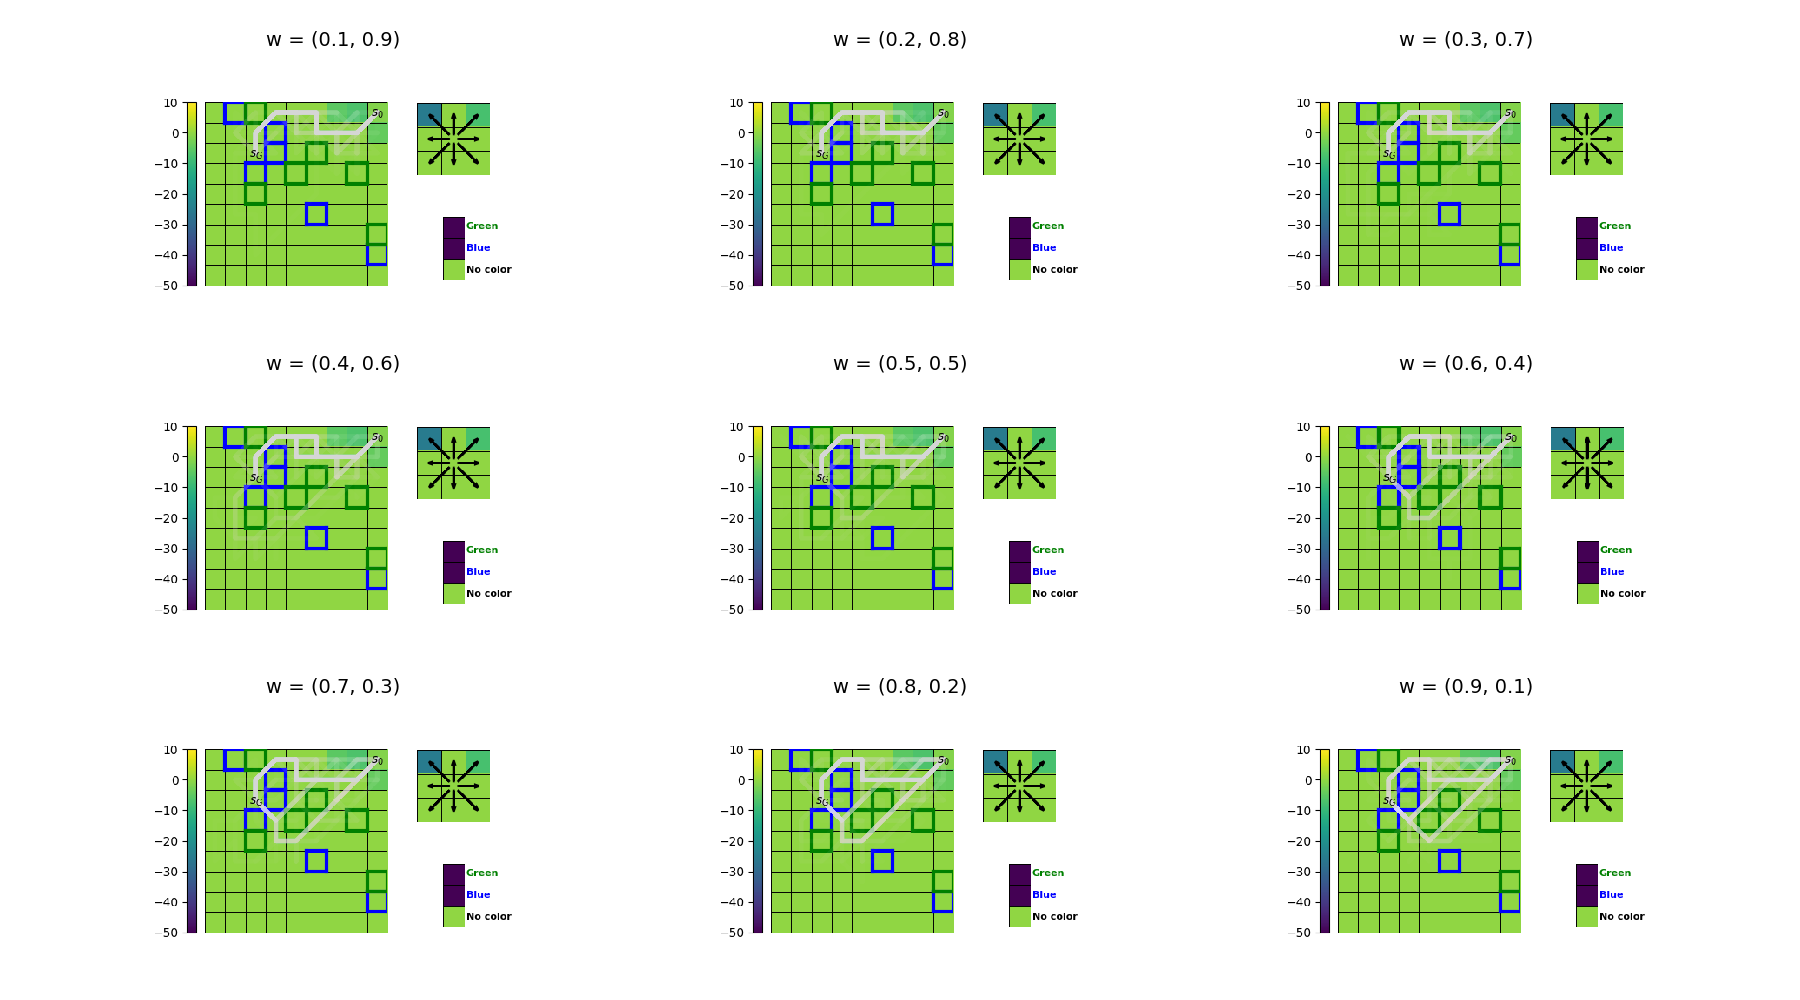

<IPython.core.display.Javascript object>


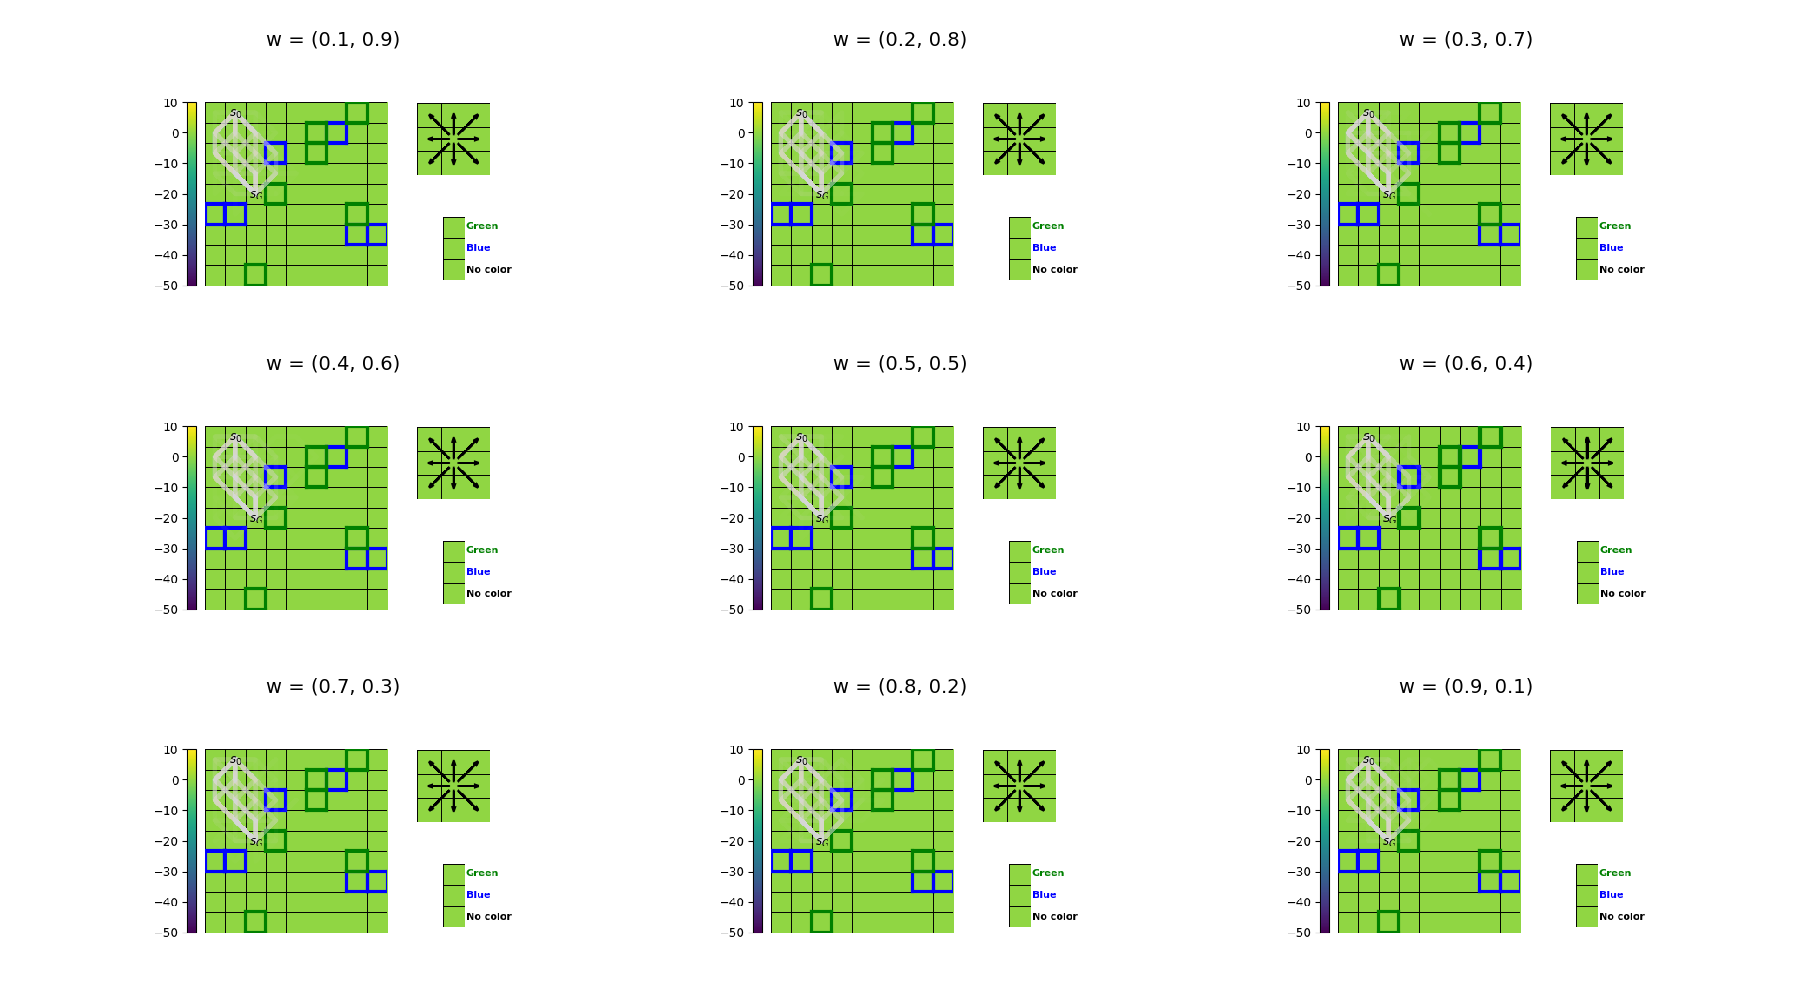

In [7]:
wrl_matrix = []   

#[n, c, learned_params, learned_mdp]

for test in range(n_tests):
    fig = plt.figure(figsize=(9, 5))
    axis = fig.subplots(3, 3)

    n_cfg = worlds[test]['n']
    c_cfg = worlds[test]['c']
    n = n_cfg.mdp
    c = c_cfg.mdp
    learned_params = worlds[test]['learned_params']
    learned_mdp = worlds[test]['learned_mdp']
    
    wrl_matrix.append([])

    for i in range(9):
        w = [(i+1)/10, 1 - (i+1)/10]
        demo_wrl = G.generate_weighted_average_trajectories(c.world, n.reward, learned_params.reward, c.start, c.terminal, w)
        temp_matrix, avg_wrl, avg_reward, avg_violated = count_states(demo_wrl[0], c)

        wrl_matrix[test].append({i: {'temp_matrix': temp_matrix, 'demo': demo_wrl, 'avg_wrl': avg_wrl, 'avg_reward':avg_reward, 'avg_violated': avg_violated}})
        
        plt.ioff()
        f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                      learned_params.action_weights, learned_params.color_weights, 
                      demo_wrl, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
        plt.close()
        plt.ion()
        canvas = FigureCanvas(f1)
        canvas.draw()
        X = np.array(canvas.renderer.buffer_rgba())

        x = i // 3
        y = i % 3
        axis[x,y].axis('off')   
        axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
        axis[x,y].imshow(X)



    fig.tight_layout()

## MDFT as orchestrator

<IPython.core.display.Javascript object>


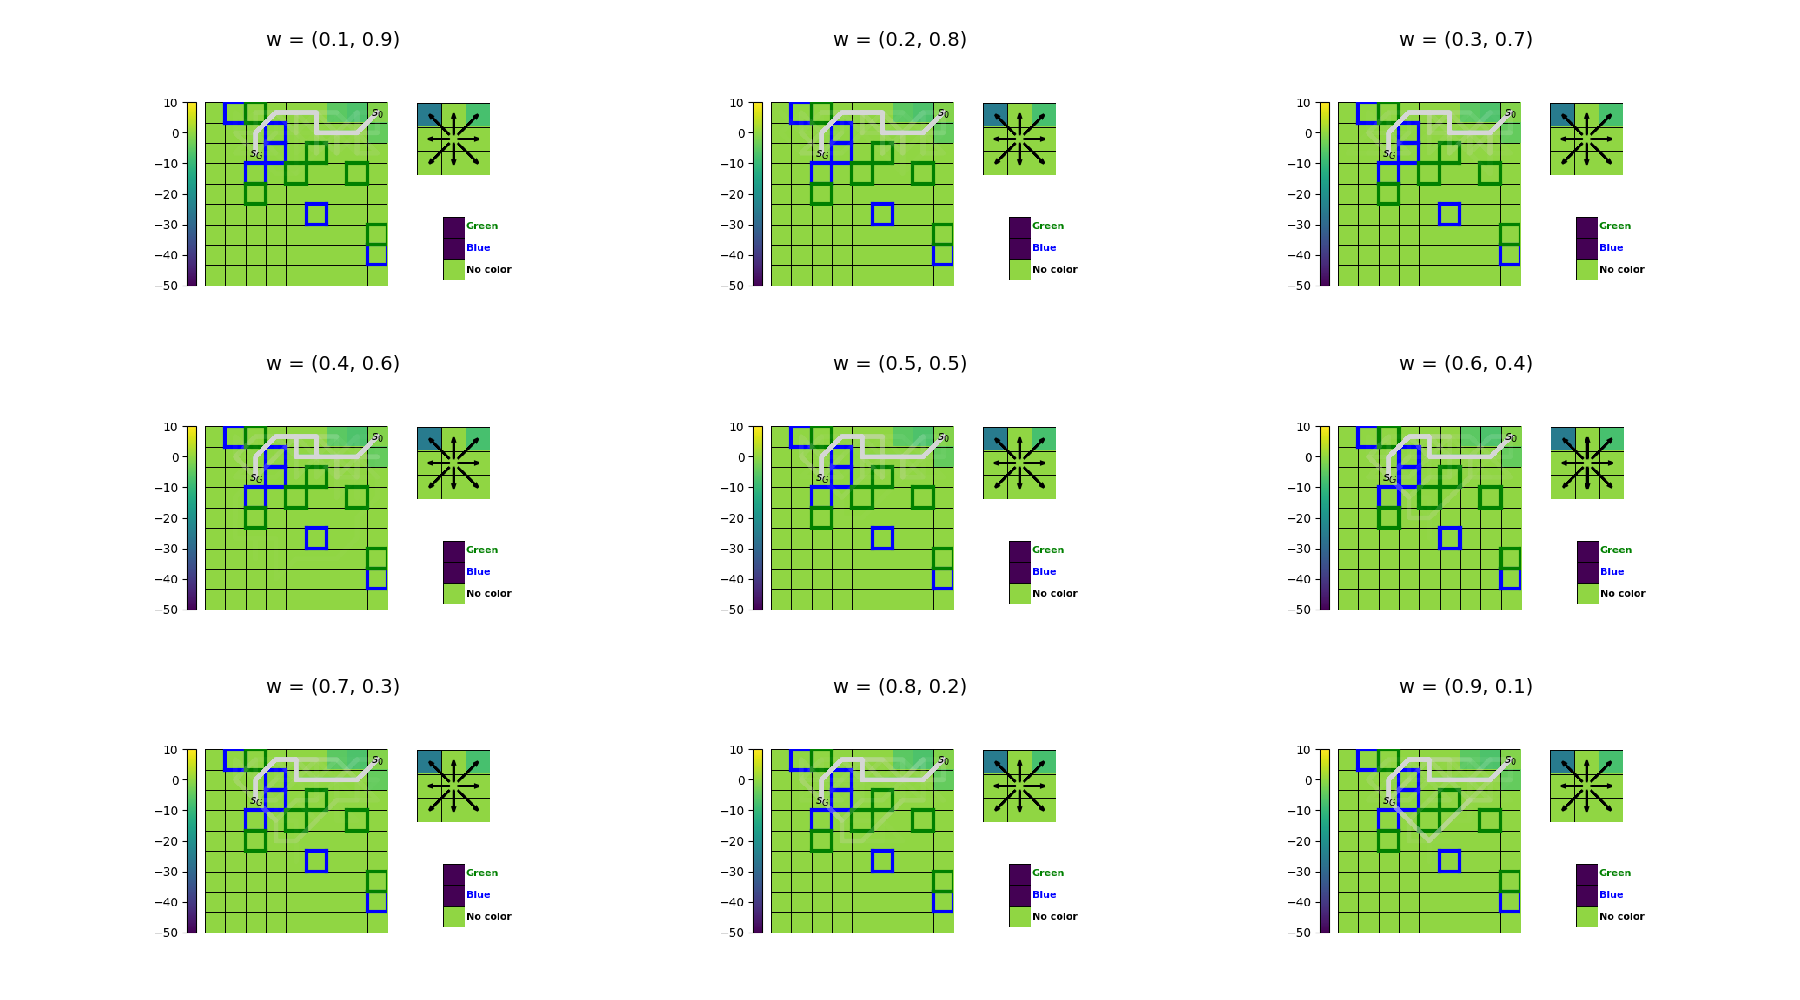

<IPython.core.display.Javascript object>


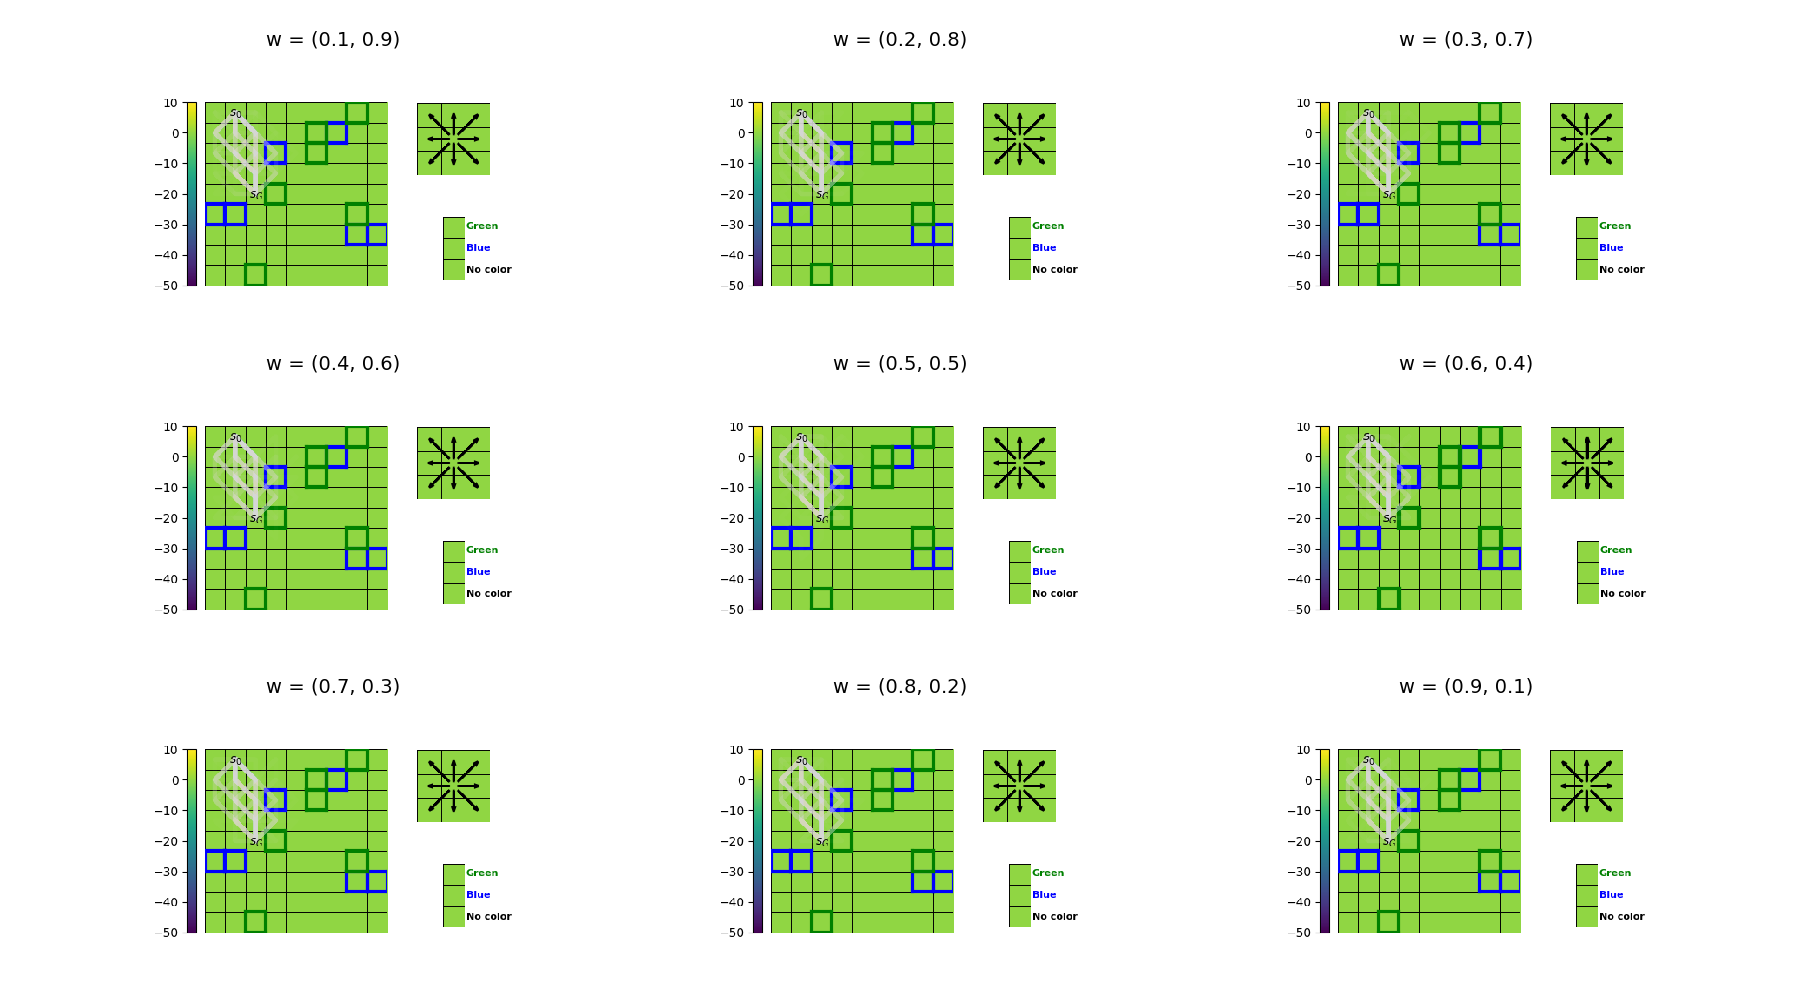

In [8]:
mdft_matrix = []   

#[n, c, learned_params, learned_mdp]

for test in range(n_tests):
    fig = plt.figure(figsize=(9, 5))
    axis = fig.subplots(3, 3)

    n_cfg = worlds[test]['n']
    c_cfg = worlds[test]['c']
    n = n_cfg.mdp
    c = c_cfg.mdp
    learned_params = worlds[test]['learned_params']
    learned_mdp = worlds[test]['learned_mdp']
    
    mdft_matrix.append([])
    
    for i in range(9):
        w = [(i+1)/10, 1 - (i+1)/10]
        demo_mdft = G.generate_mdft_trajectories(n.world, n.reward, learned_params.reward, n.start, n.terminal, w)

        temp_matrix, avg_mdft, avg_reward, avg_violated = count_states(demo_mdft[0], c)
        mdft_matrix[test].append({i: {'temp_matrix': temp_matrix, 'demo': demo_mdft, 'avg_wrl': avg_wrl, 'avg_reward':avg_reward, 'avg_violated': avg_violated}})
        
        plt.ioff()
        f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                      learned_params.action_weights, learned_params.color_weights, 
                      demo_mdft, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
        plt.close()
        plt.ion()
        canvas = FigureCanvas(f1)
        canvas.draw()
        X = np.array(canvas.renderer.buffer_rgba())

        x = i // 3
        y = i % 3
        axis[x,y].axis('off')   
        axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
        axis[x,y].imshow(X)


    fig.tight_layout()

In [55]:
print(f"\t\t MDFT \t\t WRL")
for i in range(9):
    w = [(i+1)/10, 1 - (i+1)/10]
    print(f'w = ({w[0]:0.1f}, {w[1]:0.1f})')
    p = np.reshape(wrl_matrix[i][0], (-1,1))
    q = np.reshape(mdft_matrix[i][0], (-1,1))
    
    avg_length_mdft = mdft_matrix[i][1]
    avg_length_wrl = wrl_matrix[i][1]
    avg_rew_mdft = mdft_matrix[i][2]
    avg_rew_wrl = wrl_matrix[i][2]
    avg_vc_mdft = mdft_matrix[i][3]
    avg_vc_wrl = wrl_matrix[i][3]
    print(f"AVG LENGTH: \t{avg_length_mdft}\t\t {avg_length_wrl}")
    print(f"AVG REWARD: \t{avg_rew_mdft}\t\t {avg_rew_wrl}")
    print(f"AVG VC: \t{avg_vc_mdft}\t\t {avg_vc_wrl}")
    print(f"KL(RL||MDFT) {kl_divergence(p,q)} \t KL(MDFT||RL) {kl_divergence(q,p)}")
    print(f"JS(RL||MDFT) {js_divergence(p,q)} \t JS DISTANCE {distance.jensenshannon(p,q)}")
    print("---------------------------------------------------------\n")

		 MDFT 		 WRL
w = (0.1, 0.9)
AVG LENGTH: 	9.645		 9.575
AVG REWARD: 	-17.02		 -22.585
AVG VC: 	1.195		 1.435
KL(RL||MDFT) [0.70027744] 	 KL(MDFT||RL) [1.65942123]
JS(RL||MDFT) [0.12196173] 	 JS DISTANCE [0.08923485]
---------------------------------------------------------

w = (0.2, 0.8)
AVG LENGTH: 	9.61		 9.0
AVG REWARD: 	-19.435		 -29.365
AVG VC: 	1.31		 1.575
KL(RL||MDFT) [-0.03908463] 	 KL(MDFT||RL) [2.58599425]
JS(RL||MDFT) [0.19654524] 	 JS DISTANCE [0.11307179]
---------------------------------------------------------

w = (0.3, 0.7)
AVG LENGTH: 	8.93		 6.86
AVG REWARD: 	-27.82		 -37.51
AVG VC: 	1.38		 1.525
KL(RL||MDFT) [-0.04728283] 	 KL(MDFT||RL) [6.04117229]
JS(RL||MDFT) [0.5398495] 	 JS DISTANCE [0.18816973]
---------------------------------------------------------

w = (0.4, 0.6)
AVG LENGTH: 	5.135		 5.06
AVG REWARD: 	-50.24		 -50.165
AVG VC: 	1.445		 1.56
KL(RL||MDFT) [0.71865426] 	 KL(MDFT||RL) [2.23120481]
JS(RL||MDFT) [0.17584934] 	 JS DISTANCE [0.14135355]
--------

<IPython.core.display.Javascript object>


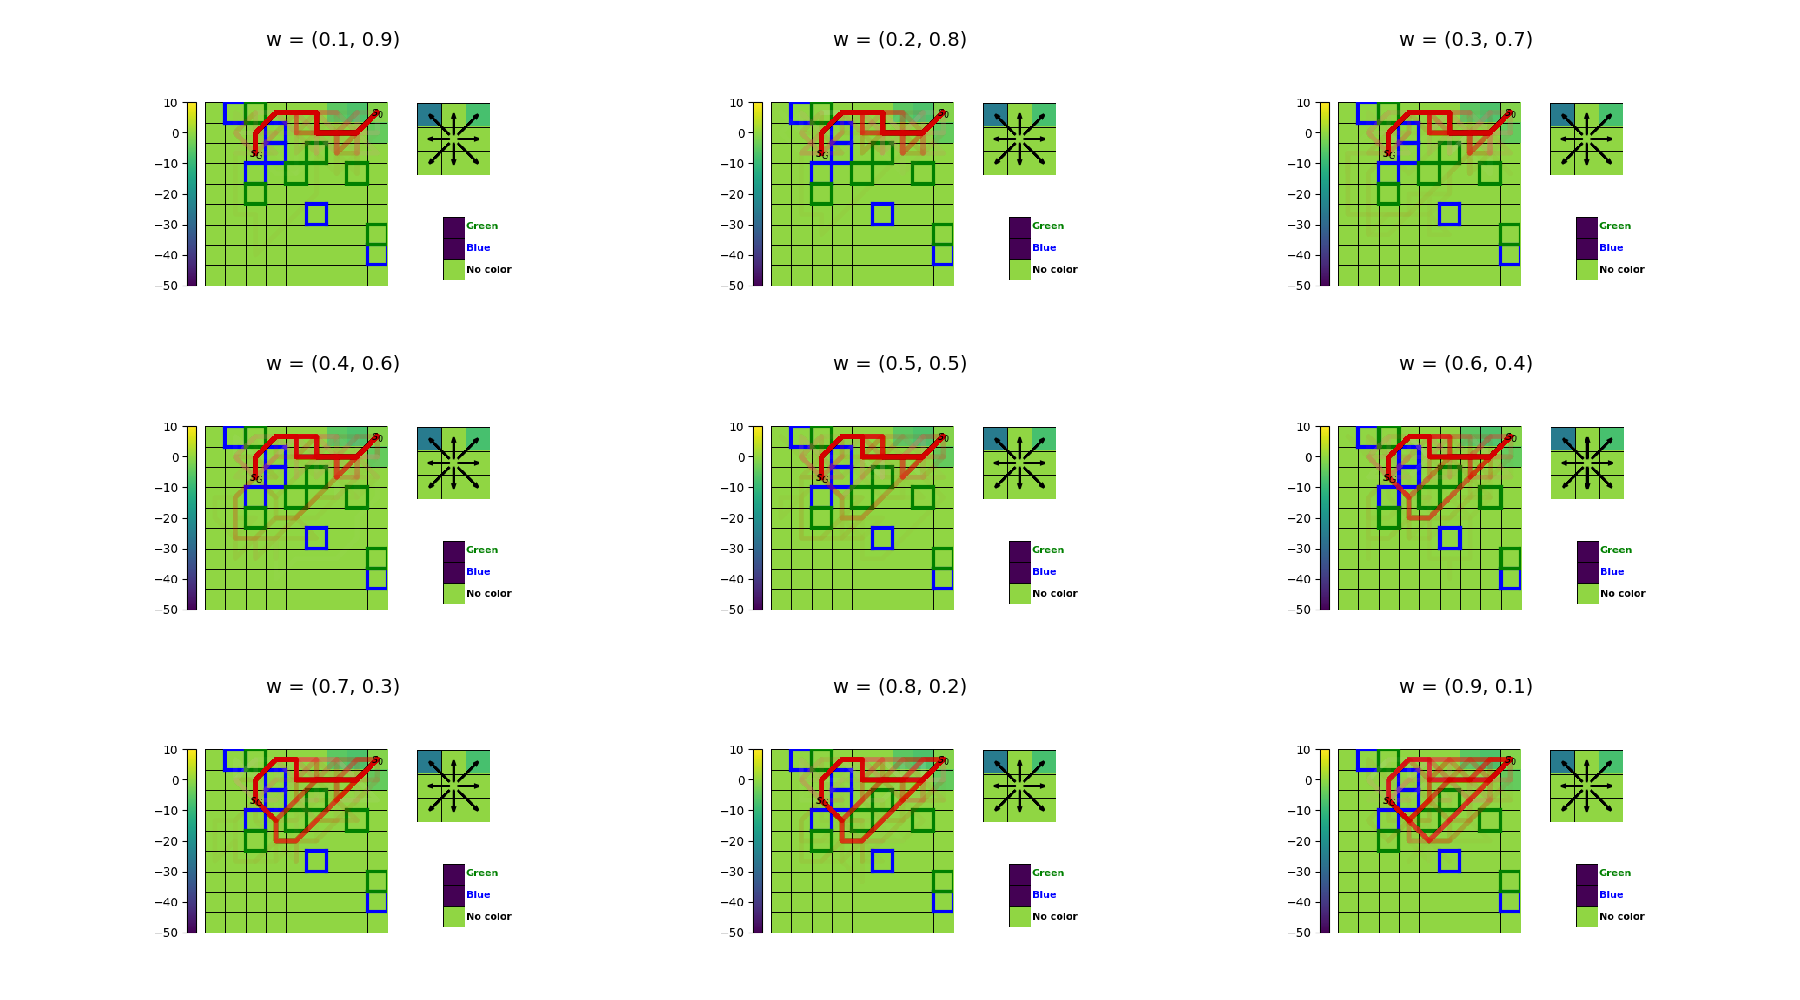

<IPython.core.display.Javascript object>


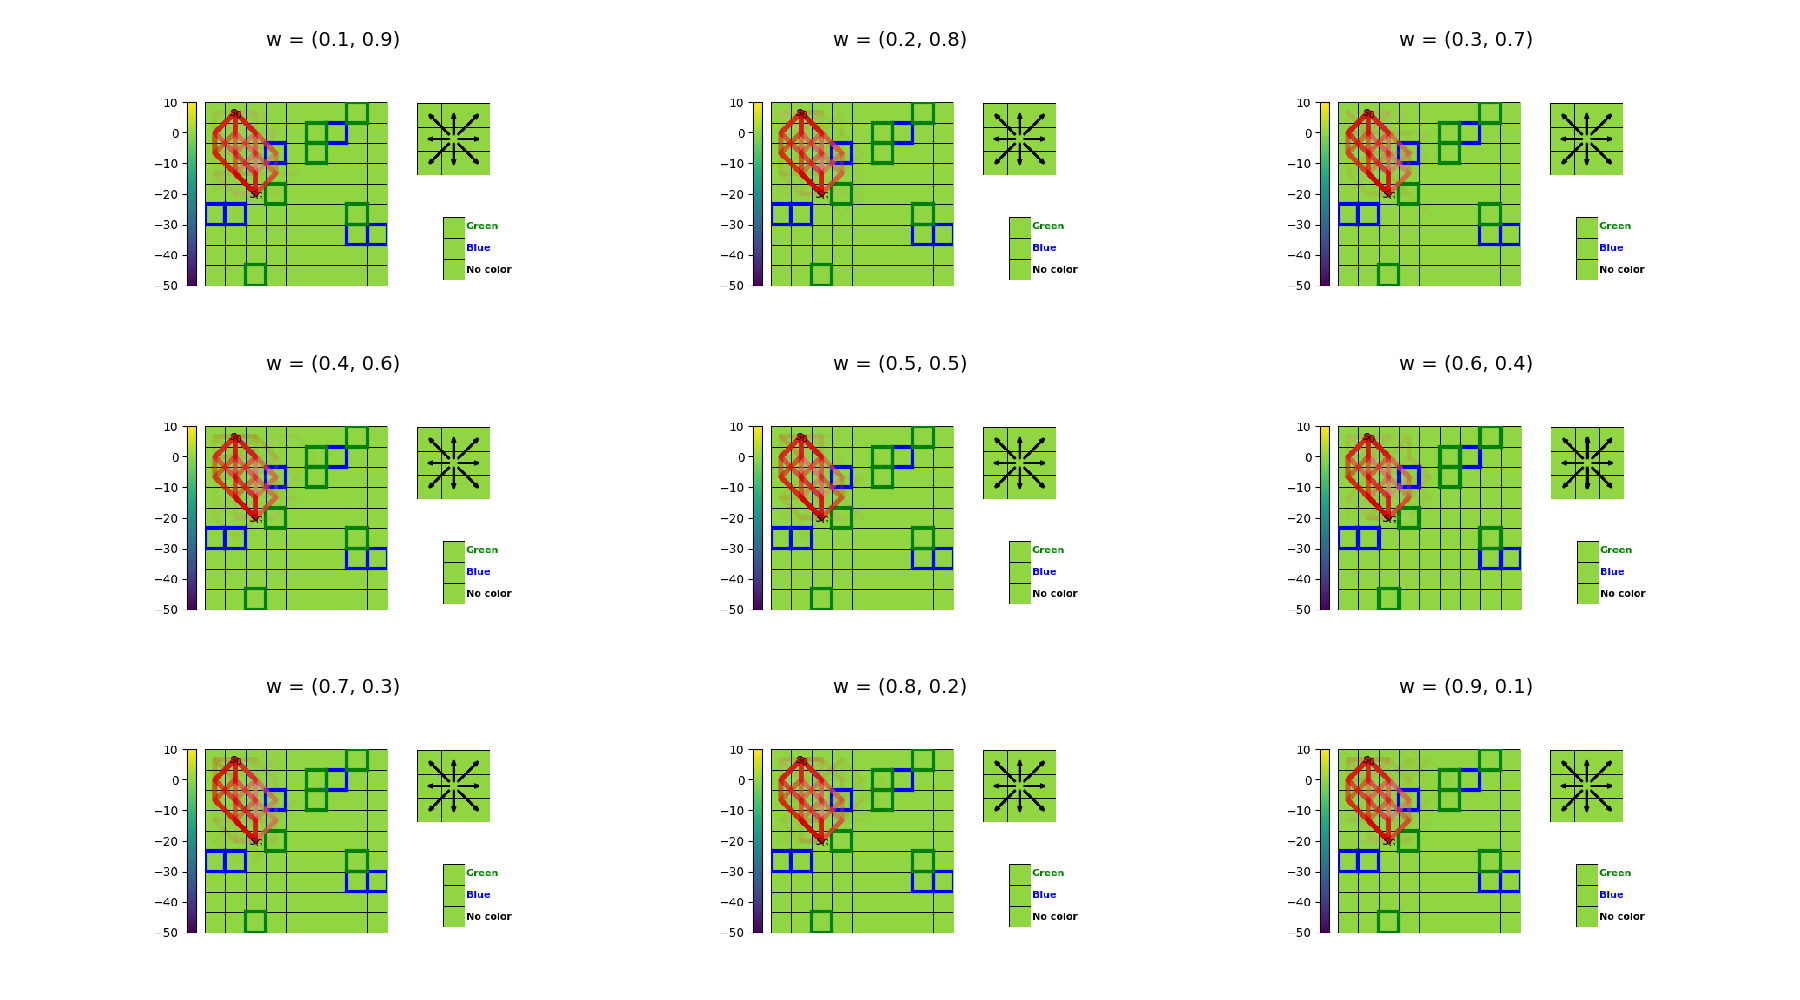

In [36]:
for test in range(n_tests):
    fig = plt.figure(figsize=(9, 5))
    axis = fig.subplots(3, 3)

    n_cfg = worlds[test]['n']
    c_cfg = worlds[test]['c']
    n = n_cfg.mdp
    c = c_cfg.mdp
    learned_params = worlds[test]['learned_params']
    learned_mdp = worlds[test]['learned_mdp']

    for i in range(9):
        w = [(i+1)/10, 1 - (i+1)/10]
        demo_mdft = mdft_matrix[test][i][i]['demo']
        demo_wrl = wrl_matrix[test][i][i]['demo']
        
        
        plt.ioff()
        f1 = G.plot_trajectory_comparison(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                      learned_params.action_weights, learned_params.color_weights, 
                      demo_mdft, demo_wrl, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
        plt.close()
        plt.ion()
        canvas = FigureCanvas(f1)
        canvas.draw()
        X = np.array(canvas.renderer.buffer_rgba())

        x = i // 3
        y = i % 3
        axis[x,y].axis('off')   
        axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
        axis[x,y].imshow(X)


    fig.tight_layout()

In [124]:
p1 = [1e-10, 1e-10, 0.5, 0.5]
p2 = [1e-10, 1e-10, 0.45, 0.55]
p3 = [0.000001, 0.999998, 0.000001]
p4 = [0.33, 0.2, 0.33333]


print(f"JS(RL||MDFT) {js_divergence(p1, p2)} \t JS DISTANCE {distance.jensenshannon(p1, p2)}")
print(f"JS(RL||MDFT) {js_divergence(p3, p4)} \t JS DISTANCE {distance.jensenshannon(p3, p4)}\n")   

worlds[1]['c']

JS(RL||MDFT) [0.00180865] 	 JS DISTANCE 0.03540709064668248
JS(RL||MDFT) [0.54163203] 	 JS DISTANCE 0.6288218459840508



MDP(world=IcyGridWorld(size=9, p_slip=0.1), reward=array([[[  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        ...,
        [ -50., -100., -100., ...,  -50.,  -50.,  -50.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.]],

       [[  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        ...,
        [ -50., -100., -100., ...,  -50.,  -50.,  -50.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.]],

       [[  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        [  -1.,  -50.,  -50., ...,   -1.,   -1.,   -1.],
        ...,
        [ -50., -100., -100., ...,  -50.,  -50.,  -